In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
df = pd.read_csv("/kaggle/input/arabicfakenews/dataset.csv",encoding='utf-8')
df

,label,text,title
0,1,يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...,المنتخب الوطني المغربي لأقل من سنة يخوض تجمعا ...
1,1,ترأس عبد القادر اعمارة وزير التجهيز و النقل و ...,وزير النقل اعمارة السرعة عامل مسبب لحوادث السي...
2,1,أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...,ميسي يؤكد أن الفوز بكأس اسبانيا كان نقطة تحول
3,1,أكّد الدبلوماسي المغربي السابق بإسبانيا عبد ال...,دبلوماسي مغربي سابق بإسبانيا خطأ مدريد مع الرب...
4,1,أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...,شركتان فرنسية وبريطانية تعلنان عن نتائج إيجابي...
...,...,...,...
374434,1,بدأت اليوم الاربعاء العطلة الصيفية في كافة الم...,تقرير مُقلق ارتفاع بنسبة في وفيات الأولاد خلال...
374435,1,حادثة مقتل الناشط السياسي نزار بنات حادثة تحدث...,اللعب بالرأي العام الفلسطيني د هاني العقاد
374436,1,لم يتفاجىء على الإطلاق أولئك الذين يتابعون بشك...,قنبلة موقوتة الشباب غير المؤطر في المجتمع العر...
374437,1,قامت راهبات وإدارة المستشفى هذا الاسبوع بتعيين...,تعيين الدكتور أيمن سليمان حصادية أخصائي طب وجر...


In [4]:
df = df.drop_duplicates()

stop_words = set(stopwords.words('arabic'))

def preprocess_text(text):
    text = ''.join(e for e in text if e.isalnum() or e.isspace())  # Suppression des caractères spéciaux
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df.loc[:, 'cleaned_text'] = df['text'].apply(preprocess_text)
df.loc[:, 'cleaned_title'] = df['title'].apply(preprocess_text)

/tmp/ipykernel_17/2356025178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cleaned_text'] = df['text'].apply(preprocess_text)
/tmp/ipykernel_17/2356025178.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cleaned_title'] = df['title'].apply(preprocess_text)


In [5]:
df['features'] = df['cleaned_title'] + " " + df['cleaned_text']

# Définir X (caractéristiques) et y (étiquettes)
X = df['features']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_17/1108920573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'] = df['cleaned_title'] + " " + df['cleaned_text']


In [6]:
stop_words_arabic = stopwords.words('arabic')

In [7]:
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words_arabic)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


(297868, 5000)


In [8]:
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

lr_pred = lr_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.7715766715457854
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     33236
           1       0.78      0.82      0.80     41231

    accuracy                           0.77     74467
   macro avg       0.77      0.77      0.77     74467
weighted avg       0.77      0.77      0.77     74467



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


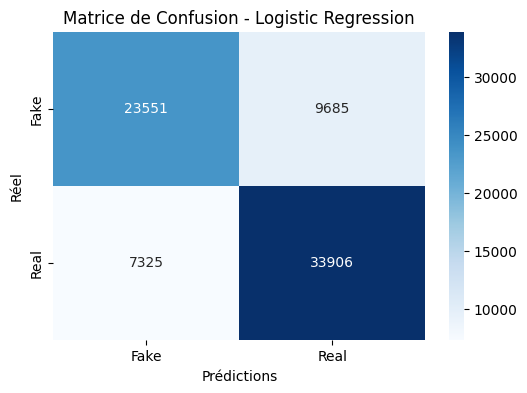

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

lr_cm = confusion_matrix(y_test, lr_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Matrice de Confusion - Logistic Regression')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error

lr_pred = lr_model.predict(X_test_tfidf)
mse = mean_squared_error(y_test, lr_pred)
print(f"Mean Squared Error (MSE) : {mse}")

Mean Squared Error (MSE) : 0.22842332845421462


In [11]:
import xgboost as xgb

Accuracy: 0.8001
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.76     33236
           1       0.78      0.89      0.83     41231

    accuracy                           0.80     74467
   macro avg       0.81      0.79      0.79     74467
weighted avg       0.80      0.80      0.80     74467



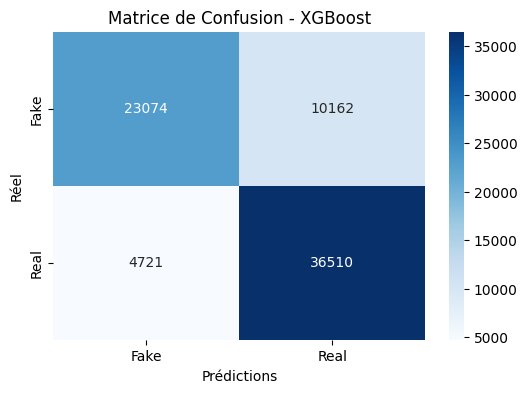

In [12]:
# Ajout d'un ensemble de validation pour le suivi des métriques
eval_set = [(X_train_tfidf, y_train), (X_test_tfidf, y_test)]

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric=['logloss', 'error'])
xgb_model.fit(X_train_tfidf, y_train, eval_set=eval_set, verbose=False)


results = xgb_model.evals_result()

xgb_pred = xgb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, xgb_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, xgb_pred))

xgb_cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Matrice de Confusion - XGBoost')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

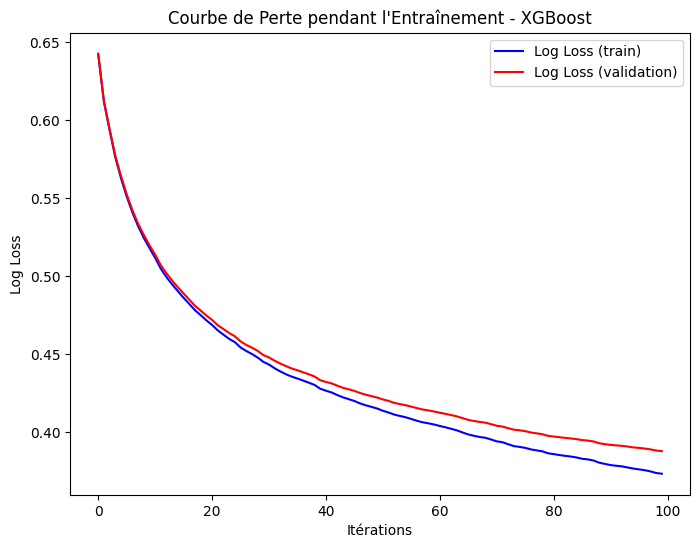

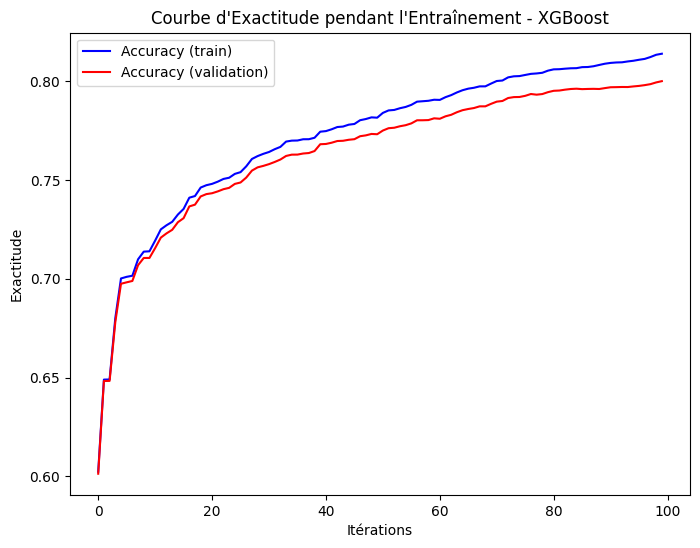

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(results['validation_0']['logloss'], label='Log Loss (train)', color='blue')
plt.plot(results['validation_1']['logloss'], label='Log Loss (validation)', color='red')
plt.title('Courbe de Perte pendant l\'Entraînement - XGBoost')
plt.xlabel('Itérations')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

# Tracer la courbe d'exactitude
train_accuracy = [1 - e for e in results['validation_0']['error']]
val_accuracy = [1 - e for e in results['validation_1']['error']]

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Accuracy (train)', color='blue')
plt.plot(val_accuracy, label='Accuracy (validation)', color='red')
plt.title('Courbe d\'Exactitude pendant l\'Entraînement - XGBoost')
plt.xlabel('Itérations')
plt.ylabel('Exactitude')
plt.legend()
plt.show()

****BILSTM****

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Tokenizer et vectorisation du texte
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Appliquer le padding pour avoir des séquences de longueur fixe
max_len = 128  # Longueur maximale des séquences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Création du modèle BiLSTM avec régularisation
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Augmenter la taille de LSTM
model.add(Dropout(0.7))  # Augmenter le taux de Dropout

# Ajouter une deuxième couche LSTM
model.add(LSTM(64, return_sequences=False))  # Réduction de la dimension
model.add(Dropout(0.7))  # Ajouter Dropout à la deuxième couche LSTM

# Couche de sortie
model.add(Dense(1, activation='sigmoid'))  # Classification binaire (0 ou 1)

# Compiler le modèle avec un taux d'apprentissage réduit
optimizer = Adam(learning_rate=0.0001)  # Réduire le taux d'apprentissage
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Utiliser EarlyStopping et ReduceLROnPlateau pour régulariser l'entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Entraînement du modèle avec les callbacks
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Prédictions sur l'ensemble de test
biLSTM_pred = (model.predict(X_test_pad) > 0.5).astype(int)

# Calcul de l'exactitude
biLSTM_accuracy = accuracy_score(y_test, biLSTM_pred)
print(f"BiLSTM Accuracy: {biLSTM_accuracy * 100:.2f}%")

# Affichage du rapport de classification
print(classification_report(y_test, biLSTM_pred))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
4655/4655 ━━━━━━━━━━━━━━━━━━━━ 2219s 475ms/step - accuracy: 0.6836 - loss: 0.5559 - val_accuracy: 0.7674 - val_loss: 0.4343 - learning_rate: 1.0000e-04
Epoch 2/10
4655/4655 ━━━━━━━━━━━━━━━━━━━━ 2215s 476ms/step - accuracy: 0.7764 - loss: 0.4240 - val_accuracy: 0.7734 - val_loss: 0.4210 - learning_rate: 1.0000e-04
Epoch 3/10
4655/4655 ━━━━━━━━━━━━━━━━━━━━ 2251s 484ms/step - accuracy: 0.7858 - loss: 0.4054 - val_accuracy: 0.7767 - val_loss: 0.4127 - learning_rate: 1.0000e-04
Epoch 4/10
4655/4655 ━━━━━━━━━━━━━━━━━━━━ 2215s 476ms/step - accuracy: 0.7969 - loss: 0.3872 - val_accuracy: 0.7828 - val_loss: 0.4091 - learning_rate: 1.0000e-04
Epoch 5/10
4655/4655 ━━━━━━━━━━━━━━━━━━━━ 2213s 475ms/step - accuracy: 0.8085 - loss: 0.3691 - val_accuracy: 0.7883 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 6/10
4655/4655 ━━━━━━━━━━━━━━━━━━━━ 2234s 480ms/step - accuracy: 0.8173 - loss: 0.3551 - val_accuracy: 0.7888 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 7/10
4655/4655 ━

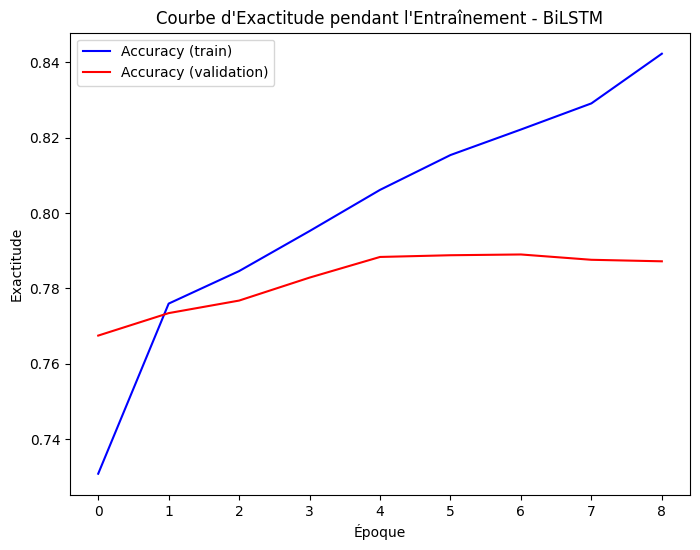

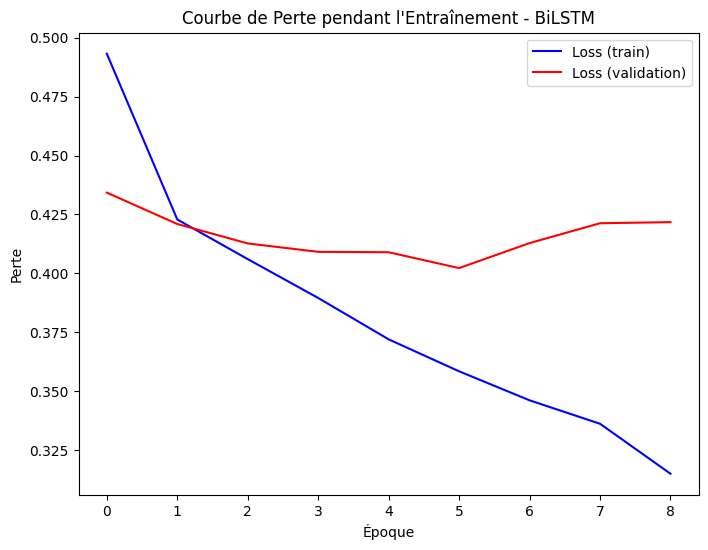

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Accuracy (train)', color='blue')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)', color='red')
plt.title('Courbe d\'Exactitude pendant l\'Entraînement - BiLSTM')
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss (train)', color='blue')
plt.plot(history.history['val_loss'], label='Loss (validation)', color='red')
plt.title('Courbe de Perte pendant l\'Entraînement - BiLSTM')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()

**LSTM Classique**